# Deep learning — Lab on uncertainty
In this lab, you will:

 - Implement a simple calibration method
 - Analyze the calibration of a model
 - Plot reliability curves
 - Explore the effect of label smoothing
 - Implement and assess the effect of focal loss
 - If time permits, code up the per-class Expected Calibration Error (ECE)

Apart from the Questions, there are instruction comments throughout the notebook as well as comments inside the code cells beginning with two hashtags (##). In addition, there are #**START CODE  /  #**END CODE comments indicating the start and end of your code sections. Pay attention not to delete these comments.

## 1. Temperature scaling
As you have seen during the course, calibration quantifies how much your softmax outputs indicate the degree of certainty of your model. Most deep learning models today are miscalibrated.

We will analyze the calibration of a simple pretrained model on ImageNet.

In [ ]:
import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

We will build a simple linear probing head on top of a ResNet50 model.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        ## START CODE
        self.model = torchvision.models.resnet50(pretrained=True)
        self.head = nn.Linear(self.model.fc.in_features, num_classes)
        self.model.fc = nn.Identity()
        ## END CODE
        for parameter in self.model.parameters():
            parameter.required_grad = False

    def forward(self, x):
        x = self.model(x)
        x = self.head(x)
        return x

Build the dataset, which is the imagenette2 dataset, consisting of 10 classes



In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 10
LR = 0.0001
NUM_EPOCHS = 5
TRAIN_SUBSET = 1000
VAL_SUBSET = 500
TEST_SUBSET = 500

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}.')
torch.random.manual_seed(0)
random.seed(0)

Running on cuda.


In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Resize((224, 224))])
download = not os.path.exists('imagenette2')
train_dataset = torchvision.datasets.Imagenette('.', download=download, split='train', transform=transforms)

subset_idx = np.random.choice(np.arange(len(train_dataset)), size=TRAIN_SUBSET+VAL_SUBSET+TEST_SUBSET, replace=False)
random.shuffle(subset_idx)
train_idx = subset_idx[:TRAIN_SUBSET]
val_idx = subset_idx[TRAIN_SUBSET:-TEST_SUBSET]
test_idx = subset_idx[-TEST_SUBSET:]
## START CODE
val_dataset = torch.utils.data.Subset(train_dataset, val_idx)
test_dataset = torch.utils.data.Subset(train_dataset, test_idx)
train_dataset = torch.utils.data.Subset(train_dataset, train_idx)
## END CODE

100%|██████████| 1.56G/1.56G [01:53<00:00, 13.7MB/s]


Extracting ./imagenette2.tgz to .


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Define the model, optimizer and criterion

In [ ]:
## START CODE
model = Model(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss()
## END CODE

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training and validation loop

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_losses, train_f1s = [], []
    model.train()
    for train_x, train_y in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        ## START CODE
        train_pred = F.softmax(model(train_x.to(device)), -1)
        train_loss = criterion(train_pred, F.one_hot(train_y, num_classes=NUM_CLASSES).float().to(device))
        train_loss.backward()
        optimizer.step()
        ## END CODE
        train_losses.append(train_loss.item())
        train_f1s.append(f1_score(train_y.cpu().detach().numpy(), np.argmax(train_pred.cpu().detach().numpy(), axis=1), average='macro'))
    print(f'Train epoch {epoch+1} | Loss: {np.mean(train_losses):.4f} | F1: {np.mean(train_f1s):.4f}')

    val_losses, val_f1s = [], []
    model.eval()
    for val_x, val_y in tqdm(val_dataloader, leave=False):
        with torch.no_grad():
            val_pred = F.softmax(model(val_x.to(device)), -1)
            val_loss = criterion(val_pred, F.one_hot(val_y, num_classes=NUM_CLASSES).float().to(device))
        val_losses.append(val_loss.item())
        val_f1s.append(f1_score(val_y.cpu().detach().numpy(), np.argmax(val_pred.cpu().detach().numpy(), axis=1), average='macro'))
    print(f'Val epoch {epoch+1} | Loss: {np.mean(val_losses):.4f} | F1: {np.mean(val_f1s):.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 1 | Loss: 0.1129 | F1: 0.8213


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 1 | Loss: 0.0289 | F1: 0.9192


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 2 | Loss: 0.0173 | F1: 0.9522


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 2 | Loss: 0.0183 | F1: 0.9736


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 3 | Loss: 0.0091 | F1: 0.9783


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 3 | Loss: 0.0162 | F1: 0.9669


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 4 | Loss: 0.0064 | F1: 0.9883


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 4 | Loss: 0.0188 | F1: 0.9368


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 5 | Loss: 0.0030 | F1: 0.9965


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 5 | Loss: 0.0170 | F1: 0.9423


In [ ]:
model.eval()
test_logits, test_labels = [], []
for test_x, test_y in test_dataset:
    with torch.no_grad():
        test_x = test_x.unsqueeze(0).to(device)
        test_pred = model(test_x)
    test_logits.append(test_pred.detach().cpu())
    test_labels.append(test_y)
test_logits = np.vstack(test_logits)
test_labels = np.array(test_labels)
test_probs = F.softmax(torch.tensor(test_logits), -1).numpy()

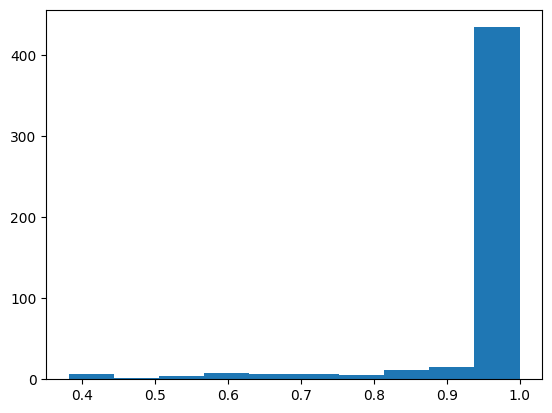

In [ ]:
plt.hist(test_probs.max(-1), bins=10)
plt.show()

In [ ]:
def expected_calibration_error(probs, labels, num_bins=10):
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidence = np.max(probs, axis=1)
    pred_class = np.argmax(probs, axis=1)
    ece = 0

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        ## START CODE
        in_bin = (confidence >= bin_lower) & (confidence < bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(pred_class[in_bin] == labels[in_bin])
            avg_confidence_in_bin = np.mean(confidence[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        ## END CODE
    return ece

In [ ]:
expected_calibration_error(probs=test_probs, labels=test_labels)

0.007540136992931406

In [ ]:
T = 1.06
b = np.exp(test_logits/T) / np.sum(np.exp(test_logits/T), axis=1, keepdims=True)

In [ ]:
expected_calibration_error(probs=b, labels=test_labels)

0.013881740331649808

In [ ]:
import torch.nn.functional as F

def smooth_labels(y, smoothing=0.0009):
    """Apply label smoothing."""
    num_classes = y.size(-1)
    ## START CODE
    return y * (1.0 - smoothing) + smoothing / num_classes
    ## END CODE

In [ ]:
model = Model(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(NUM_EPOCHS):
    train_losses, train_f1s = [], []
    model.train()
    for train_x, train_y in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        train_pred = F.softmax(model(train_x.to(device)), -1)

        one_hot_labels = F.one_hot(train_y, num_classes=NUM_CLASSES).float().to(device)
        smoothed_labels = smooth_labels(one_hot_labels)

        train_loss = criterion(train_pred, smoothed_labels)

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        train_f1s.append(f1_score(train_y.cpu().detach().numpy(),
                                  np.argmax(train_pred.cpu().detach().numpy(), axis=1),
                                  average='macro'))

    print(f'Train epoch {epoch+1} | Loss: {np.mean(train_losses):.4f} | F1: {np.mean(train_f1s):.4f}')

    # Validation loop
    val_losses, val_f1s = [], []
    model.eval()
    for val_x, val_y in tqdm(val_dataloader, leave=False):
        with torch.no_grad():
            val_pred = F.softmax(model(val_x.to(device)), -1)

            one_hot_val_labels = F.one_hot(val_y, num_classes=NUM_CLASSES).float().to(device)
            smoothed_val_labels = smooth_labels(one_hot_val_labels)

            val_loss = criterion(val_pred, smoothed_val_labels)

        # Track metrics
        val_losses.append(val_loss.item())
        val_f1s.append(f1_score(val_y.cpu().detach().numpy(),
                                np.argmax(val_pred.cpu().detach().numpy(), axis=1),
                                average='macro'))

    print(f'Val epoch {epoch+1} | Loss: {np.mean(val_losses):.4f} | F1: {np.mean(val_f1s):.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 1 | Loss: 0.1176 | F1: 0.7926


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 1 | Loss: 0.0227 | F1: 0.9544


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 2 | Loss: 0.0188 | F1: 0.9635


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 2 | Loss: 0.0209 | F1: 0.9517


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 3 | Loss: 0.0110 | F1: 0.9770


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 3 | Loss: 0.0202 | F1: 0.9520


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 4 | Loss: 0.0084 | F1: 0.9898


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 4 | Loss: 0.0220 | F1: 0.9452


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 5 | Loss: 0.0052 | F1: 0.9929


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 5 | Loss: 0.0164 | F1: 0.9525


In [ ]:
model.eval()
test_logits, test_labels = [], []
for test_x, test_y in test_dataset:
    with torch.no_grad():
        test_x = test_x.unsqueeze(0).to(device)
        test_pred = model(test_x)
    test_logits.append(test_pred.detach().cpu())
    test_labels.append(test_y)
test_logits = np.vstack(test_logits)
test_labels = np.array(test_labels)
test_probs = F.softmax(torch.tensor(test_logits), -1).numpy()

In [ ]:
expected_calibration_error(probs=test_probs, labels=test_labels)

0.016433952689170805

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha*(1-pt)**self.gamma*BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
gamma_val = 1.0
alpha_val = 0.25
criterion = FocalLoss(gamma=gamma_val, alpha=alpha_val)

Train the model using the focal loss

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_losses, train_f1s = [], []
    model.train()
    for train_x, train_y in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        train_pred = F.softmax(model(train_x.to(device)), -1)
        train_loss = criterion(train_pred, F.one_hot(train_y, num_classes=NUM_CLASSES).float().to(device))
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        train_f1s.append(f1_score(train_y.cpu().detach().numpy(), np.argmax(train_pred.cpu().detach().numpy(), axis=1), average='macro'))
    print(f'Train epoch {epoch+1} | Loss: {np.mean(train_losses):.4f} | F1: {np.mean(train_f1s):.4f}')

    val_losses, val_f1s = [], []
    model.eval()
    for val_x, val_y in tqdm(val_dataloader, leave=False):
        with torch.no_grad():
            val_pred = F.softmax(model(val_x.to(device)), -1)
            val_loss = criterion(val_pred, F.one_hot(val_y, num_classes=NUM_CLASSES).float().to(device))
        val_losses.append(val_loss.item())
        val_f1s.append(f1_score(val_y.cpu().detach().numpy(), np.argmax(val_pred.cpu().detach().numpy(), axis=1), average='macro'))
    print(f'Val epoch {epoch+1} | Loss: {np.mean(val_losses):.4f} | F1: {np.mean(val_f1s):.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 1 | Loss: 0.2837 | F1: 0.9939


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 1 | Loss: 0.2925 | F1: 0.9638


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 2 | Loss: 0.2826 | F1: 0.9985


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 2 | Loss: 0.2914 | F1: 0.9538


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 3 | Loss: 0.2828 | F1: 0.9925


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 3 | Loss: 0.2906 | F1: 0.9512


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 4 | Loss: 0.2838 | F1: 0.9885


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 4 | Loss: 0.2947 | F1: 0.9438


  0%|          | 0/32 [00:00<?, ?it/s]

Train epoch 5 | Loss: 0.2831 | F1: 0.9914


  0%|          | 0/16 [00:00<?, ?it/s]

Val epoch 5 | Loss: 0.2928 | F1: 0.9426


In [ ]:
model.eval()
test_logits, test_labels = [], []
for test_x, test_y in test_dataset:
    with torch.no_grad():
        test_x = test_x.unsqueeze(0).to(device)
        test_pred = model(test_x)
    test_logits.append(test_pred.detach().cpu())
    test_labels.append(test_y)
test_logits = np.vstack(test_logits)
test_labels = np.array(test_labels)
test_probs = F.softmax(torch.tensor(test_logits), -1).numpy()